### dataset

In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
import torch.nn.functional as F
import argparse
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.optim as optim
import math
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import torch.nn.init as init

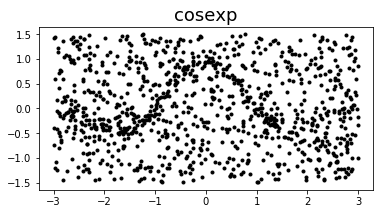

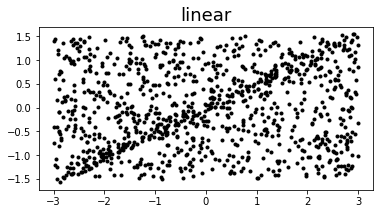

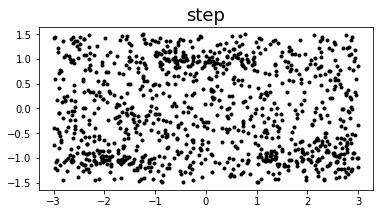

In [2]:
# from Choice's
def f_cosexp(x): return np.cos(np.pi/2*x)*np.exp(-(x/2)**2)
def f_linear(x): return 0.5*x
def f_step(x):
    n = x.shape[0]
    t = np.zeros(shape=(n,1))
    for i in range(n):
        if x[i] < -1: t[i] = -1.0
        elif x[i] < +1: t[i] = +1.0
        else: t[i] = -1.0
    return t
def data4reg(_type='',_n=1000,_oRange=[-1.5,+1.5],_oRate=0.1,measVar=0.01):
    np.random.seed(seed=0) # Fix random seed
    _xmin,_xmax = -3,+3
    x = np.float32(np.random.uniform(_xmin,_xmax,((int)(_n),1)))
    x.sort(axis=0)
    if _type == 'cosexp': t = f_cosexp(x)
    elif _type == 'linear': t = f_linear(x)
    elif _type == 'step': t = f_step(x)
    else: print ("Unknown function type [%s]."%(_type))
    # Add measurement nosie
    y = t + np.sqrt(measVar)*np.random.randn(_n,1)
    # Switch to outliers 
    nOutlier = (int)(_n*_oRate) # Number of outliers
    y[np.random.permutation((int)(_n))[:nOutlier],:] \
        = _oRange[0]+np.random.rand(nOutlier,1)*(_oRange[1]-_oRange[0])
    return x,y,t
def plot_1dRegData(_x,_y,_t,_type='',_figSize=(6,3)):
    plt.figure(figsize=_figSize) # Plot
    # ht,=plt.plot(_x,_t,'ro')
    hd,=plt.plot(_x,_y,'k.')
    # plt.legend([ht,hd],['Target function','Training data'],fontsize=15)
    plt.title('%s'%(_type),fontsize=18)
    plt.show()
# Demo Usage 
if __name__ == "__main__":
    for tIdx,_type in enumerate(['cosexp','linear','step']):
        _x,_y,_t=data4reg(_type=_type,_n=1000,_oRange=[-1.5,+1.5],_oRate=0.8,measVar=1e-2)
        plot_1dRegData(_x,_y,_t,_type)

In [3]:
from choicenet import network

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [4]:
num_mixture = 10

In [5]:
class TestM(nn.Module):
    def __init__(self):
        super(TestM, self).__init__()
        self.b = nn.Linear(1, 64)
        self.mcdn = network.MDCN(64, num_mixture, device="cuda:0")
    
    def forward(self, x):
        f = self.b(x)
        f = f.view(f.size(0), -1)
        return self.mcdn(f)

In [10]:
def gaussian_distribution(y, mu, sigma):
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(torch.sqrt(sigma))) * 1.0 / np.sqrt(2.0*math.pi)


def loss_(pred, target):
    # pred : pi, mu, var / target : int
    pi = pred[0]
    mu = pred[1]
    var = pred[2]
    
    l_ = gaussian_distribution(target, mu, var) * pi
    l_ = torch.sum(l_, dim=1)
    l_ = torch.mean(-torch.log(l_))
    
    
    a = nn.MSELoss()(mu[:,0], target)
    b = l_
    
    return a + 0.1 * l_

In [11]:
x,y,t = data4reg(_type=_type,_n=1000,_oRange=[-1.5,+1.5],_oRate=0.1,measVar=1e-2)

In [12]:
def sampler(model, _x, num_mixture, n_samples=1, _deterministic=False):
  model.train(False)
  pi, mu, var = model(_x)
  n_points = _x.shape[0]
  _y_sampled = torch.zeros([n_points, n_samples])

  #print('mu',mu)
  #print('pi',pi)
  for i in range(n_points):
    for j in range(n_samples):
      if _deterministic: k=0
      else: k=np.random.choice(num_mixture,size=1, p=pi[i,:].view(-1).detach().numpy())
      #print(pi[i,:].view(-1).detach().numpy(), k)
      _y_sampled[i,j] = mu[i,k]
      
  return _y_sampled

tensor(1.4241, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


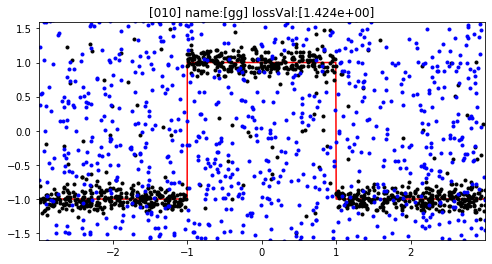

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.2023, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


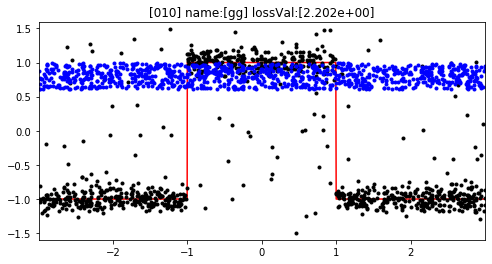

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


tensor(5.9787, device='cuda:0', grad_fn=<AddBackward0>)


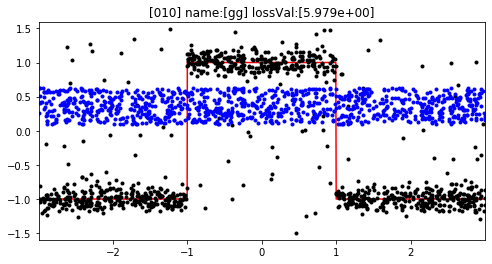

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.8937, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


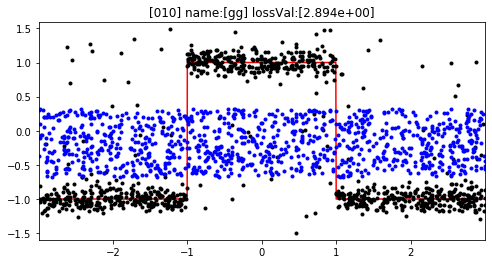

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


tensor(1.8789, device='cuda:0', grad_fn=<AddBackward0>)


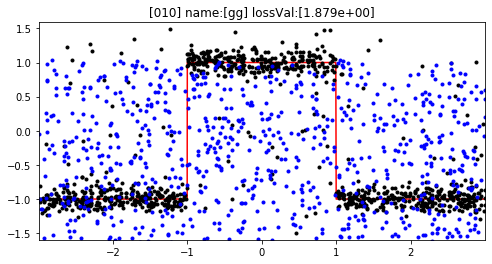

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.2559, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


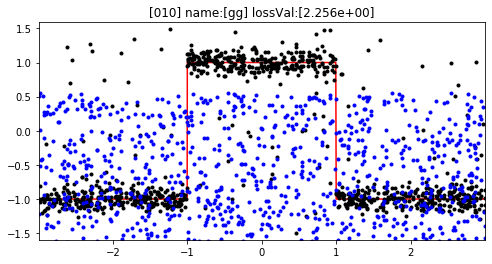

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(3.1088, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


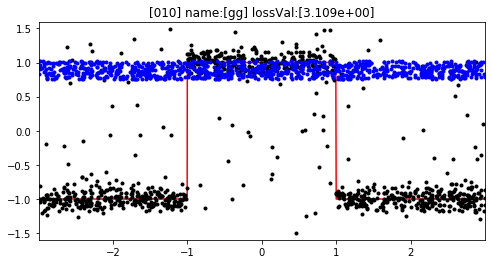

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(3.5492, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


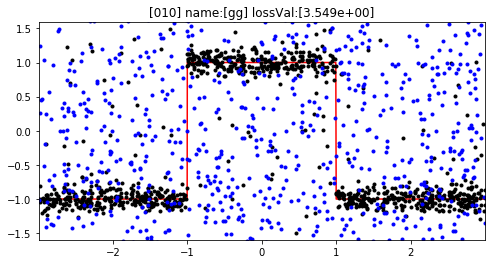

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


tensor(1.9028, device='cuda:0', grad_fn=<AddBackward0>)


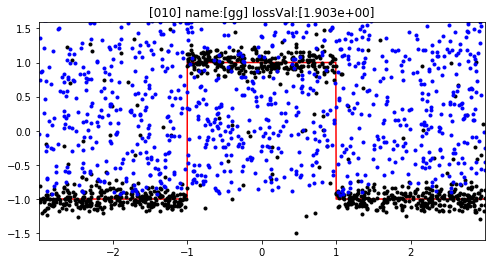

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(7.1711, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


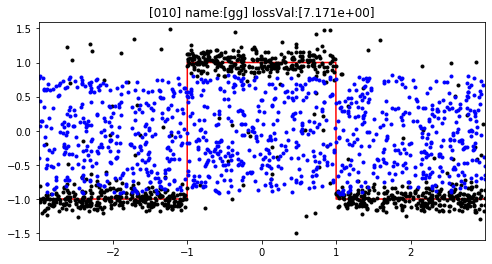

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.3144, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


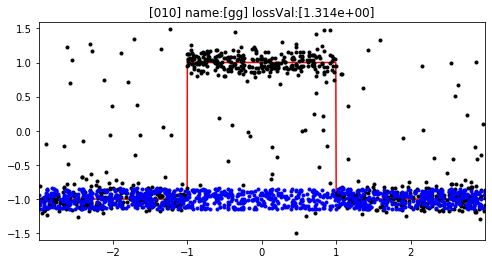

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


tensor(3.0171, device='cuda:0', grad_fn=<AddBackward0>)


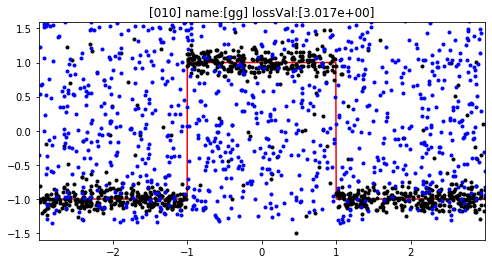

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.3766, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


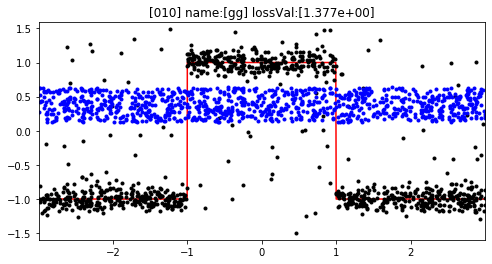

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.3804, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


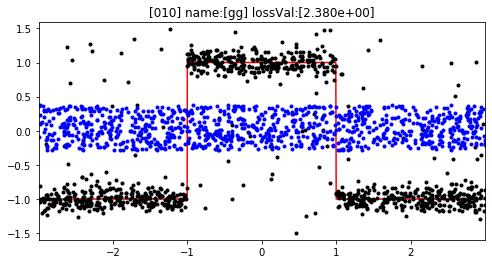

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.0965, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


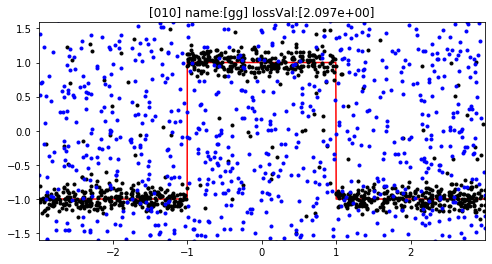

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.9471, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


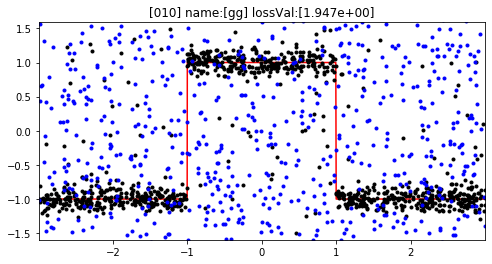

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.1571, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


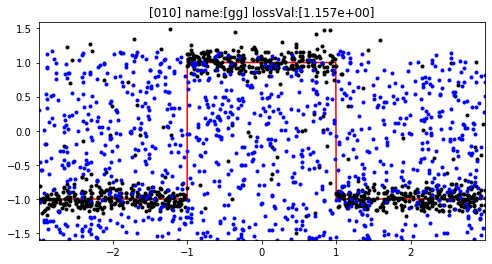

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.3052, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


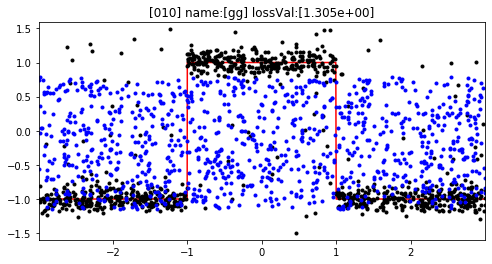

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(3.8063, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


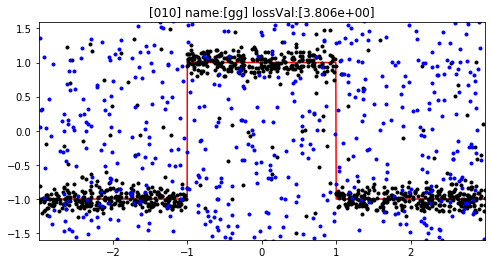

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.5761, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


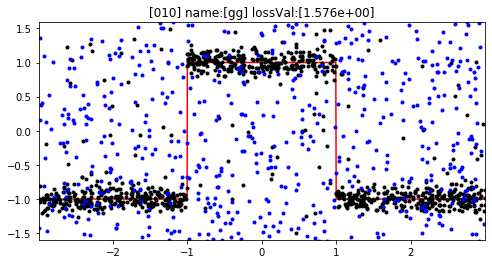

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(4.6359, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


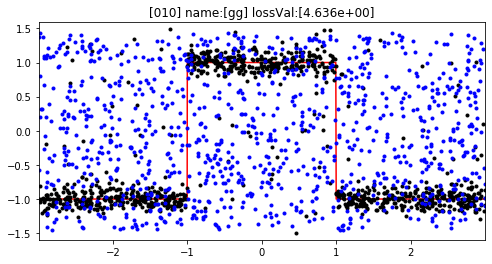

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.8897, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


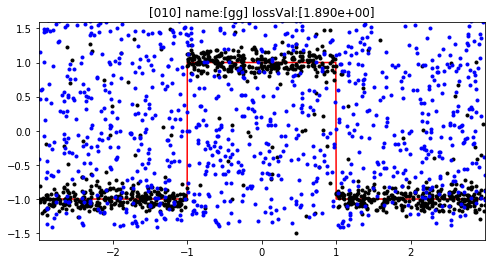

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(8.2095, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


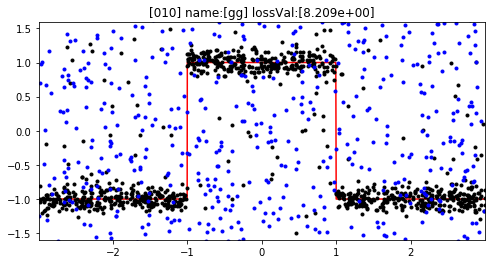

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.4308, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


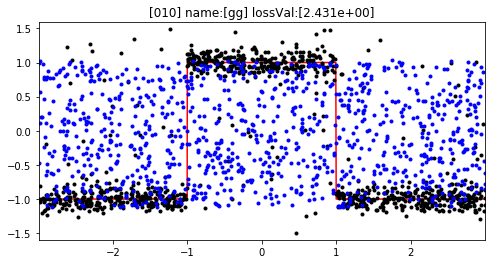

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.6524, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


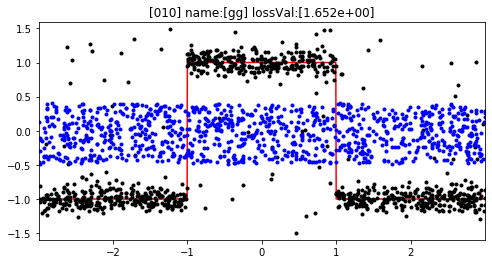

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.2323, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


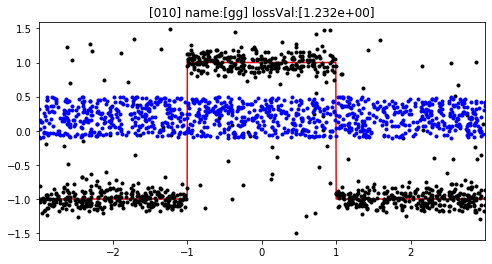

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.7396, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


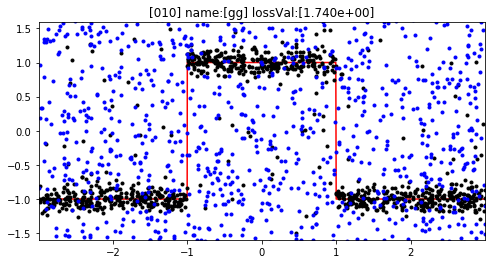

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(4.2279, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


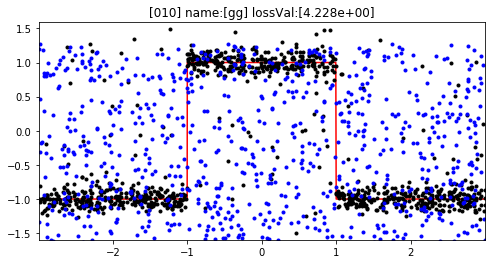

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.2396, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


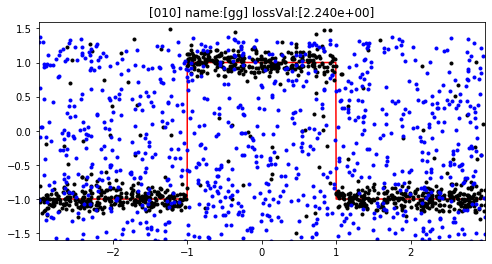

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.2370, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


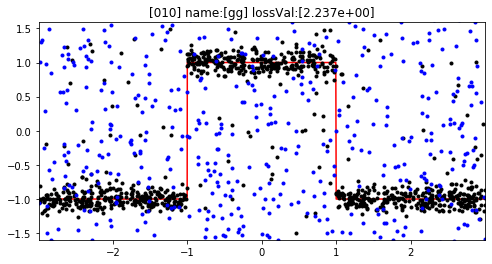

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.2865, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


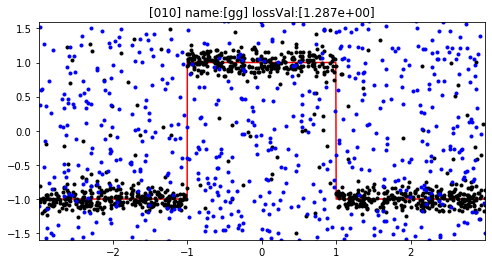

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.1222, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


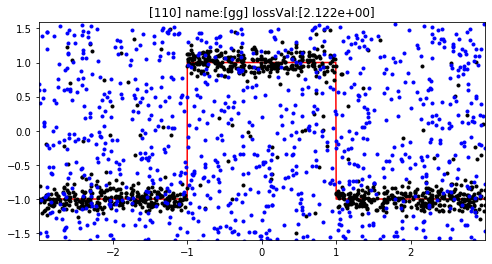

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.2212, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


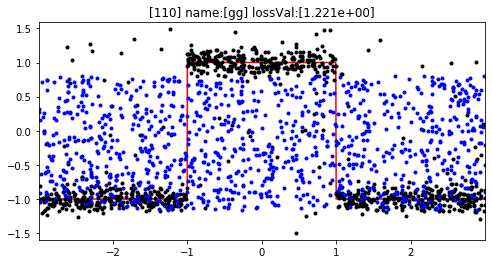

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.0731, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


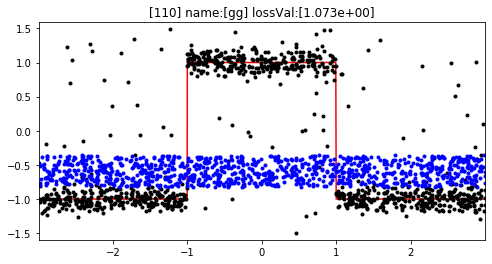

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.8652, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


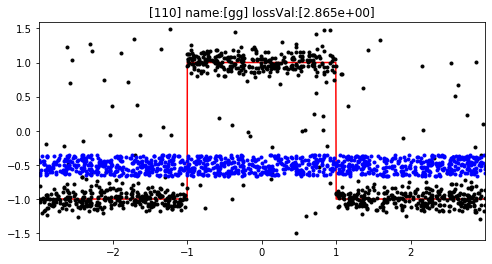

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.7643, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


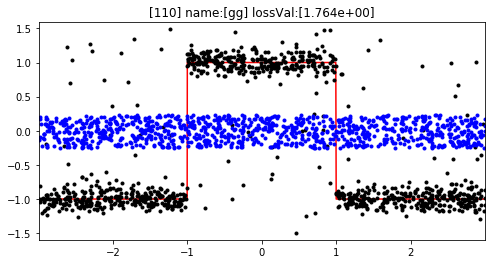

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


tensor(2.5334, device='cuda:0', grad_fn=<AddBackward0>)


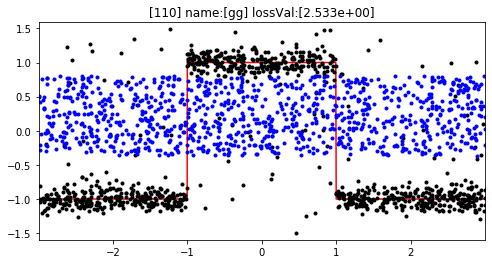

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.6030, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


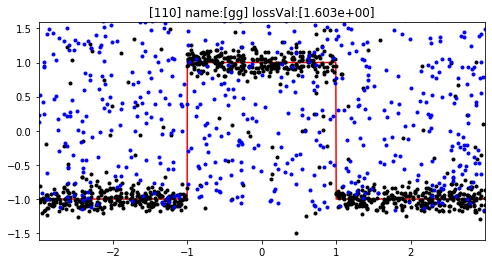

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.3662, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


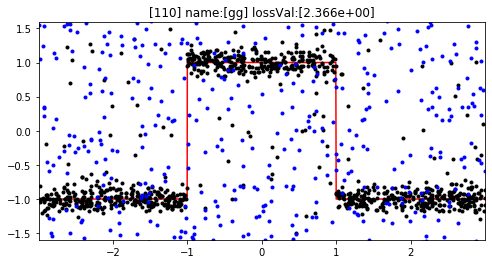

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.3331, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


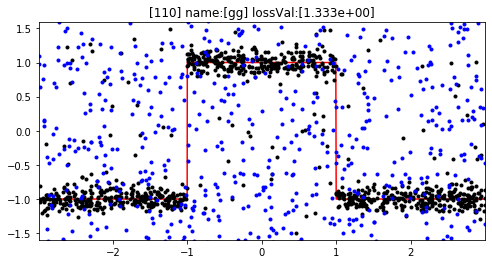

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.5584, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


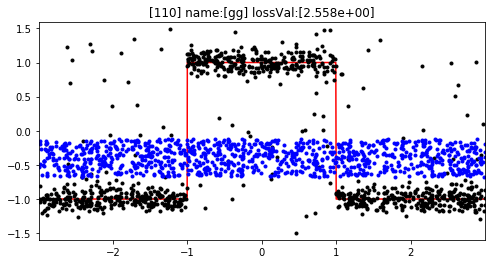

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.3819, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


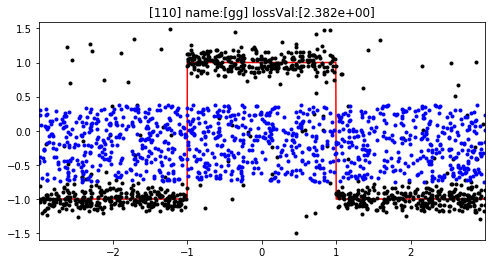

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(5.8560, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


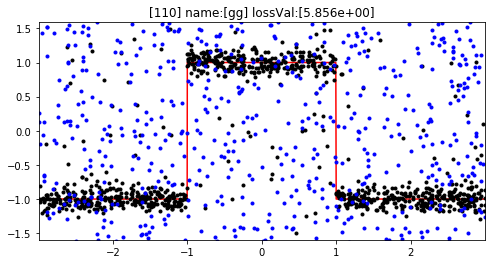

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.1049, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


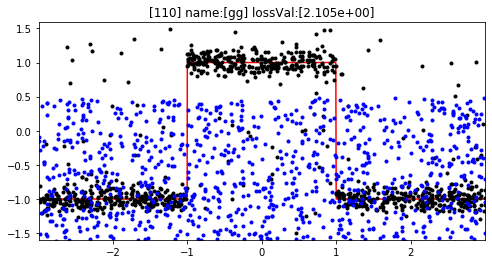

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.1893, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


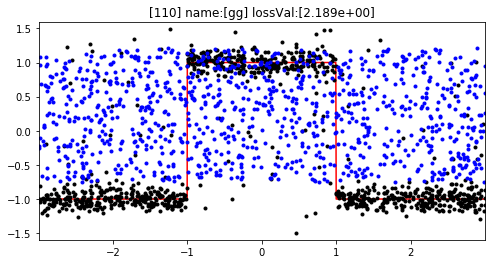

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.3545, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


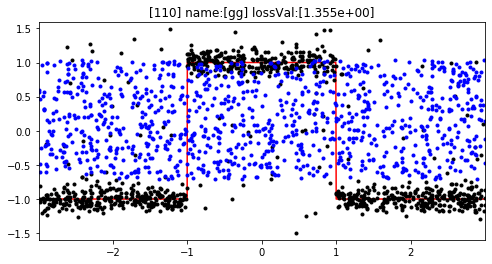

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.3219, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


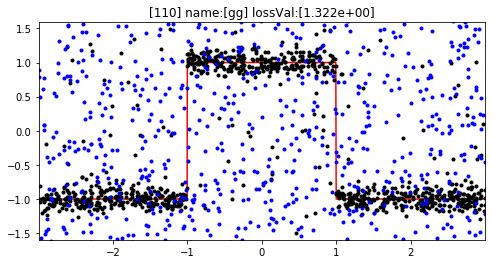

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.9013, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


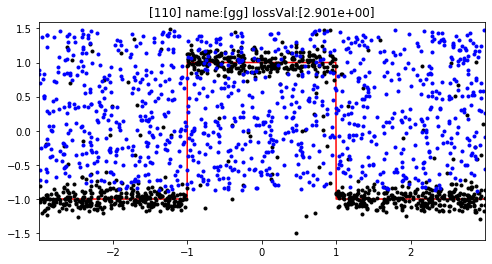

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.1949, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


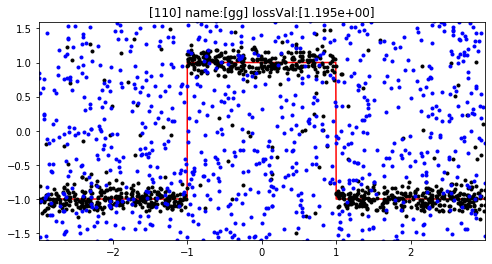

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


tensor(2.6186, device='cuda:0', grad_fn=<AddBackward0>)


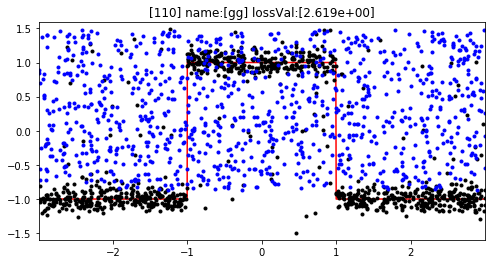

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(4.3387, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


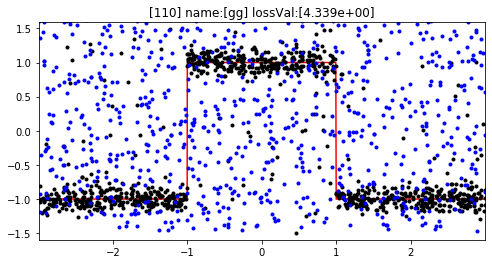

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.8925, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


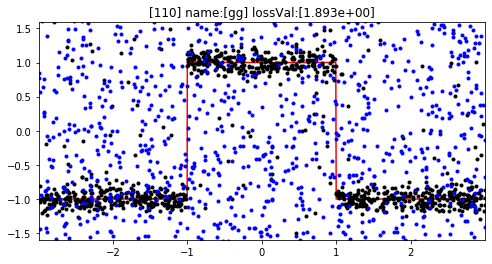

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


tensor(1.6034, device='cuda:0', grad_fn=<AddBackward0>)


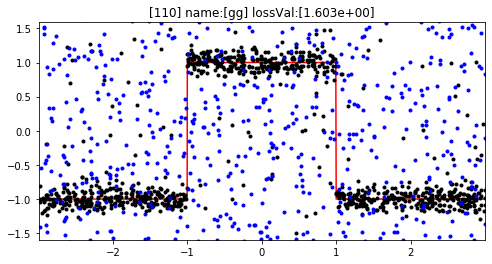

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.2440, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


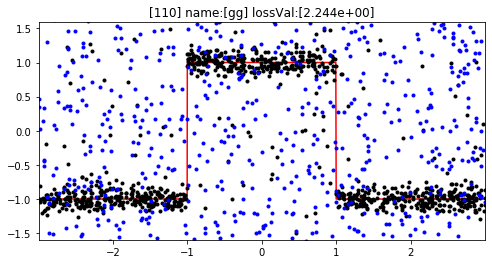

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(3.4955, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


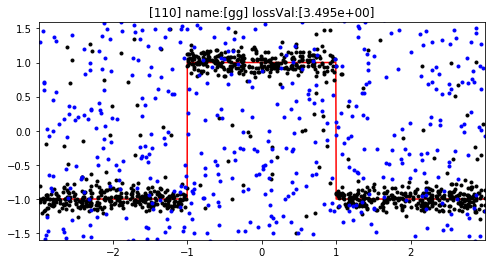

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.7572, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


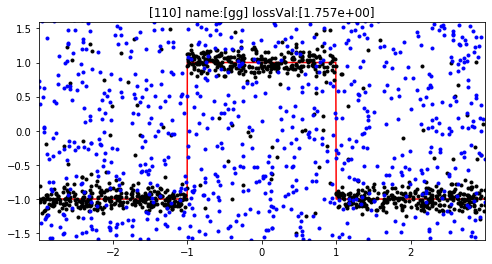

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(4.3916, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


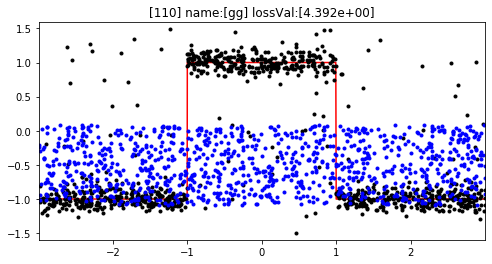

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.8650, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


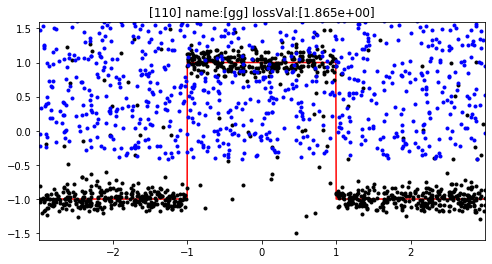

C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\dcho\Anaconda3\envs\torch_py36\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
model = TestM()
_x = x
_y = y
_yref = t
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
batchSize = 32
maxEpoch = 10
lr = 1e-3

model.train()
_x_train, _y_train = torch.from_numpy(_x),torch.from_numpy(_y)
maxIter = max(_x_train.shape[0]//batchSize,1)
bestLossVal = np.inf
for epoch in range((int)(maxEpoch)+1):
  train_rate = (float)(epoch/maxEpoch)
  _x_train,_y_train = shuffle(_x_train,_y_train)
  x_train, y_train = Variable(_x_train).float().cuda(),Variable(_y_train).float().cuda()
  for iter in range(maxIter):
    start, end = iter*batchSize,(iter+1)*batchSize
    lr_use = lr
    optimizer.zero_grad()
    model = model.cuda()
    #print('rho : ',rho,'\nmu : ', mu,'\nvar :' ,var,'\npi : ', pi)
    output = model(x_train)
    loss = loss_(output, y_train)
    loss.backward()
    print(loss)
    #print(acc)
    optimizer.step()
    nSample = 1
    ytest = sampler(model, _x=x_train, num_mixture=10, n_samples=1, _deterministic=True)
    #print(ytest)
    ytest = ytest.detach().numpy()
    x_plot, y_plot = _x[:,0], _y[:,0]
    plt.figure(figsize=(8,4))
    plt.axis([np.min(x_plot), np.max(x_plot), np.min(y_plot)-0.1, np.max(y_plot)+0.1])
    if _yref != '':
      plt.plot(x_plot,_yref[:,0],'r')
    plt.plot(x_plot, y_plot, 'k.')
   
    for i in range(nSample):
      plt.plot(_x,ytest[:,i],'b.')
    plt.title("[%d%d] name:[%s] lossVal:[%.3e]"%(epoch,maxEpoch,'gg',loss.item()))
    plt.show()
    # if batch_idx%args['log_interval'] == 0:
    #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
    #       epoch, batch_idx * len(data), len(train_loader.dataset),
    #       100. *batch_idx/len(train_loader), loss.data
    #   ))